## 4. Probabalistic Clustering using K-Means
So far, station usage types were derived from a single k-means clustering applied to features aggregated over the full observation period of each station.

However, the temporal coverage differs between stations, as shown below.

As a consequence, cluster assignments may depend on the chosen observation window. To assess the temporal robustness of the clustering, we recompute the feature vectors and cluster assignments for a restricted time interval.

In [1]:
import polars as pl
from analysis.characterisation.notebooks.notebook_config import dl

rows = []

for station in dl.get_bicyle_stations():
    bd = dl.get_bicycle(station_name=station)
    min_date, max_date = bd.date_range()
    rows.append({
        "station": station,
        "start_date": min_date,
        "end_date": max_date,
    })

df_dates = pl.DataFrame(rows)

df_dates = df_dates.with_columns(
    (pl.col("end_date") - pl.col("start_date"))
        .dt.total_days()
        .alias("summed_days")
)

df_dates

station,start_date,end_date,summed_days
str,"datetime[μs, UTC]","datetime[μs, UTC]",i64
"""Ziegelhäuser Landstraße""",2019-01-31 23:00:00 UTC,2025-11-21 03:00:00 UTC,2485
"""Bahnstadtpromenade""",2020-01-31 23:00:00 UTC,2025-06-18 13:00:00 UTC,1964
"""Berliner Straße Querschnitt""",2020-01-31 23:00:00 UTC,2025-12-14 22:00:00 UTC,2143
"""Gaisbergstraße""",2015-10-31 23:00:00 UTC,2024-12-26 22:00:00 UTC,3343
"""Eppelheimer Str. Querschnitt""",2020-01-31 23:00:00 UTC,2025-12-14 22:00:00 UTC,2143
…,…,…,…
"""Thedor-Heuss-Brücke Querschnit…",2018-07-06 04:00:00 UTC,2025-12-14 22:00:00 UTC,2718
"""Hardtstraße""",2020-01-31 23:00:00 UTC,2025-12-14 22:00:00 UTC,2143
"""Rohrbacher Straße Querschnitt""",2018-10-10 22:00:00 UTC,2025-12-14 22:00:00 UTC,2622


### Temporal robustness check

We focus on the period 2021–2024, since all stations are continuously observed from 2021 onwards (excluding Ernst-Walz-Brücke West – alt, which was removed in 2018).
The resulting clustering is compared to the clustering obtained from the full data set.

Cluster consistency is quantified using the Adjusted Rand Index (ARI), which measures the agreement between two clusterings while correcting for chance agreement.

In [2]:
from analysis.characterisation.clustering import cluster_ari
from analysis.characterisation.clustering import kmeans_clustering
from analysis.characterisation.features import build_feature_df
from analysis.characterisation.notebooks.notebook_config import N_CLUSTERS

interval_21_24 = ("2021-01-01", "2024-01-01")
features_21_24 = build_feature_df(dl, interval_21_24)

features_full = build_feature_df(dl)

clustering_full = kmeans_clustering(features=features_full, k=N_CLUSTERS)
clustering_21_24 = kmeans_clustering(features=features_21_24, k=N_CLUSTERS)

score = cluster_ari(clustering_full, clustering_21_24)
print(f"Cluster Consistency Score: {score * 100:.2f}%")

Cluster Consistency Score: 78.46%


The ARI indicates that cluster assignments are sensitive to the selected time window.
This behaviour is expected, as traffic patterns may evolve over time and aggregated features depend on the available observation period.

Rather than interpreting this variability as a weakness of the feature set, it motivates a probabilistic interpretation of station usage types.

### Probabilistic station classification
Instead of assigning each station to a single fixed cluster, we repeatedly apply k-means clustering over an expanding (cumulative) time window and compute cluster membership probabilities.

For each station $s$ and usage type $u$, we define:

$$
\begin{align*}
P(\;u\;|\;s\;) = \frac{\text{Number of assignments of station s to type u}}{\text{Total number of clustering runs}}
\end{align*}
$$

#### Clustering probabilities

To obtain a probabilistic and temporally robust station classification, k-means clustering is applied repeatedly using either a sliding or a cumulative time window.

- **Sliding window (`sliding`)**: Clustering is performed on a fixed-length window (e.g. 24 months) that is shifted forward month by month.
- **Cumulative window (`cumulative`)**: Clustering is performed on an expanding window with a fixed start date.

In the following, we use a two-year sliding window, as consecutive windows differ only slightly. This allows temporal changes in station usage to be captured more effectively than with the cumulative approach, which increasingly aggregates long-term behaviour.

In [3]:
from analysis.characterisation.clustering import monthly_dates, make_interval

DATASET_START = "2016-01-01"
DATASET_END = "2025-01-01"
TIME_SERIES_MODE = "sliding"
WINDOW_MONTHS = 24


dates = monthly_dates(start=DATASET_START, end=DATASET_END)
for d in dates:
  i = make_interval(start=DATASET_START, end=d, mode=TIME_SERIES_MODE, window_months=24)
  if i is None:
    continue
  print(i)

('2016-01-01', '2018-01-01')
('2016-02-01', '2018-02-01')
('2016-03-01', '2018-03-01')
('2016-04-01', '2018-04-01')
('2016-05-01', '2018-05-01')
('2016-06-01', '2018-06-01')
('2016-07-01', '2018-07-01')
('2016-08-01', '2018-08-01')
('2016-09-01', '2018-09-01')
('2016-10-01', '2018-10-01')
('2016-11-01', '2018-11-01')
('2016-12-01', '2018-12-01')
('2017-01-01', '2019-01-01')
('2017-02-01', '2019-02-01')
('2017-03-01', '2019-03-01')
('2017-04-01', '2019-04-01')
('2017-05-01', '2019-05-01')
('2017-06-01', '2019-06-01')
('2017-07-01', '2019-07-01')
('2017-08-01', '2019-08-01')
('2017-09-01', '2019-09-01')
('2017-10-01', '2019-10-01')
('2017-11-01', '2019-11-01')
('2017-12-01', '2019-12-01')
('2018-01-01', '2020-01-01')
('2018-02-01', '2020-02-01')
('2018-03-01', '2020-03-01')
('2018-04-01', '2020-04-01')
('2018-05-01', '2020-05-01')
('2018-06-01', '2020-06-01')
('2018-07-01', '2020-07-01')
('2018-08-01', '2020-08-01')
('2018-09-01', '2020-09-01')
('2018-10-01', '2020-10-01')
('2018-11-01',

### Cluster Interpretation

K-means assigns arbitrary numeric cluster IDs without semantic meaning.  
To obtain interpretable usage types, clusters are labelled post hoc based on their aggregated feature characteristics.

For each cluster, mean feature values (DPI, WSD, SDI) are computed and standardised.

A scalar utilitarian score is defined as

$$
\text{Utilitarian Score} = \text{DPI} + \text{WSD} - \text{SDI}
$$

Clusters are ordered by this score and labelled as **recreational**, **mixed**, and **utilitarian** from low to high values.  
Labels are derived from the full-period feature representation.

In [4]:
X = build_feature_df(dl)

EXCLUDE = {"station", "valid", "cluster", "date"}

FEATURES = [
    c for c in X.columns
    if c not in EXCLUDE and X[c].dtype in (pl.Float32, pl.Float64)
]

In [5]:
from analysis.characterisation.clustering import cluster_timeseries_usage, usage_probabilities

usage = cluster_timeseries_usage(
    loader=dl,
    k=N_CLUSTERS,
    features=FEATURES,
    start=DATASET_START,
    end=DATASET_END,
    mode=TIME_SERIES_MODE,
    window_months=WINDOW_MONTHS
)

usage_probs = usage_probabilities(usage).sort(["station", "probability"], descending=True)

Perform Clustering in Interval 2016-01-01 until 2018-01-01
Perform Clustering in Interval 2016-02-01 until 2018-02-01
Perform Clustering in Interval 2016-03-01 until 2018-03-01
Perform Clustering in Interval 2016-04-01 until 2018-04-01
Perform Clustering in Interval 2016-05-01 until 2018-05-01
Perform Clustering in Interval 2016-06-01 until 2018-06-01
Perform Clustering in Interval 2016-07-01 until 2018-07-01
Perform Clustering in Interval 2016-08-01 until 2018-08-01
Perform Clustering in Interval 2016-09-01 until 2018-09-01
Perform Clustering in Interval 2016-10-01 until 2018-10-01
Perform Clustering in Interval 2016-11-01 until 2018-11-01
Perform Clustering in Interval 2016-12-01 until 2018-12-01
Perform Clustering in Interval 2017-01-01 until 2019-01-01
Perform Clustering in Interval 2017-02-01 until 2019-02-01
Perform Clustering in Interval 2017-03-01 until 2019-03-01
Perform Clustering in Interval 2017-04-01 until 2019-04-01
Perform Clustering in Interval 2017-05-01 until 2019-05-

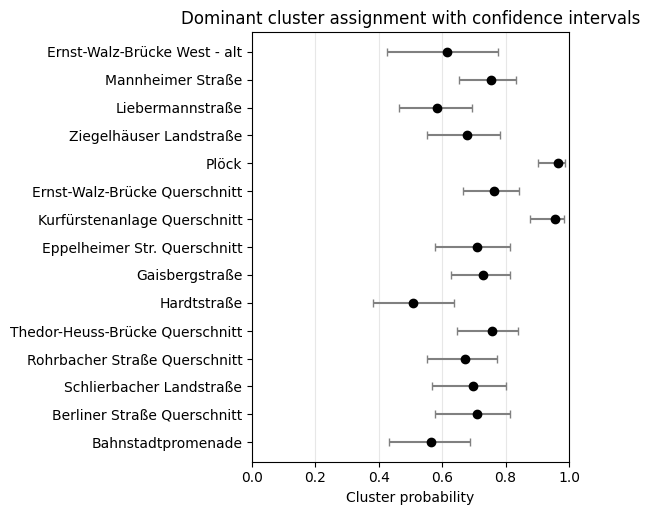

In [6]:
from analysis.characterisation.plotting.plot_clustering import plot_cluster_probabilities_ci

plot_cluster_probabilities_ci(cluster_probs_ci=usage_probs, station_col="station", prob_col="probability", lo_col="ci_low", hi_col="ci_high")

In [7]:
top_per_usage_type = (
    usage_probs
    .sort("probability", descending=True)
    .group_by("usage_type")
    .head(20)  
)

top_per_usage_type

usage_type,station,k,N,probability,ci_low,ci_high
str,str,u32,u32,f64,f64,f64
"""recreational""","""Plöck""",82,85,0.964706,0.9013,0.987925
"""recreational""","""Kurfürstenanlage Querschnitt""",64,67,0.955224,0.876422,0.984656
"""recreational""","""Thedor-Heuss-Brücke Querschnit…",56,74,0.756757,0.647937,0.840235
"""recreational""","""Eppelheimer Str. Querschnitt""",39,55,0.709091,0.578593,0.812288
"""recreational""","""Berliner Straße Querschnitt""",39,55,0.709091,0.578593,0.812288
…,…,…,…,…,…,…
"""utilitarian""","""Schlierbacher Landstraße""",17,56,0.303571,0.199003,0.433359
"""utilitarian""","""Mannheimer Straße""",18,85,0.211765,0.138362,0.310093
"""utilitarian""","""Eppelheimer Str. Querschnitt""",6,55,0.109091,0.050967,0.218255


### Temporal Stability of Station Usage Types

To quantify the temporal stability of station usage patterns, we compute the Shannon entropy of the cluster membership distribution for each station. For a station $s$ with usage probabilities $P(u \mid s)$, the entropy is defined as

$$
H(s) = -\sum_{u} P(u \mid s)\,\log P(u \mid s)
$$

In [8]:
from analysis.characterisation.helpers import entropy, dominant_usage_per_station

entropy_df = entropy(usage_probs=usage_probs)
dominant_usage = dominant_usage_per_station(usage_probs=usage_probs)

entropy_labeled = (
    entropy_df
    .join(dominant_usage, on="station", how="left")
    .sort("entropy")
)

entropy_labeled

station,entropy,usage_type,probability
str,f64,str,f64
"""Plöck""",0.152689,"""recreational""",0.964706
"""Kurfürstenanlage Querschnitt""",0.182837,"""recreational""",0.955224
"""Ernst-Walz-Brücke Querschnitt""",0.545595,"""utilitarian""",0.764706
"""Gaisbergstraße""",0.583843,"""utilitarian""",0.729412
"""Schlierbacher Landstraße""",0.61386,"""mixed""",0.696429
…,…,…,…
"""Hardtstraße""",0.692982,"""mixed""",0.509091
"""Berliner Straße Querschnitt""",0.71257,"""recreational""",0.709091
"""Bahnstadtpromenade""",0.760606,"""mixed""",0.563636


Stations with near-deterministic usage probabilities show minimal entropy, indicating stable temporal behaviour.

Higher entropy values occur predominantly for mixed-use stations (see plot below), reflecting structurally variable or context-dependent usage patterns.

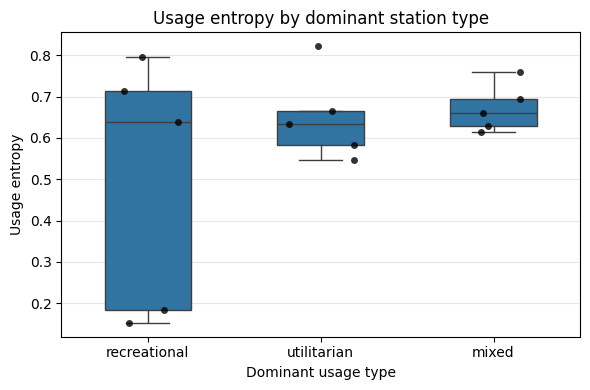

In [9]:
from analysis.characterisation.plotting.plot_clustering import plot_usage_entropy

plot_usage_entropy(entropy_df=entropy_labeled)

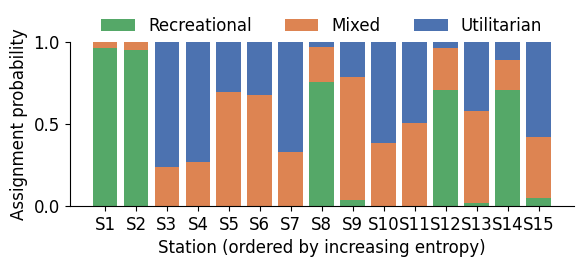

In [10]:
from analysis.characterisation.plotting.plot_clustering import plot_usage_probabilities_paper

plot_usage_probabilities_paper(usage_probs=usage_probs,savepath="clustering_prob")

## Indices
As before we can now compare the hourly, daily and monthly indices in respect to the assigned usage type.
To do this we first filter the stations after their dominant usage type. 

In [11]:
from analysis.characterisation.clustering import dominant_usage


stations_utilitarian = (
    dominant_usage(usage_probs)
    .filter(pl.col("usage_type") == "utilitarian")
    .select("station")
    .to_series()
    .to_list()
)
stations_recreational = (
    dominant_usage(usage_probs)
    .filter(pl.col("usage_type") == "recreational")
    .select("station")
    .to_series()
    .to_list()
)
stations_mixed = (
    dominant_usage(usage_probs)
    .filter(pl.col("usage_type") == "mixed")
    .select("station")
    .to_series()
    .to_list()
)

**Hourly index**

As we can see in the following plots, recreational stations have less pronounced utilitarian peaks while having large amount of weekend traffic. 

Utilitarian and mixed stations differentiate in the amount of weekend traffic they have.

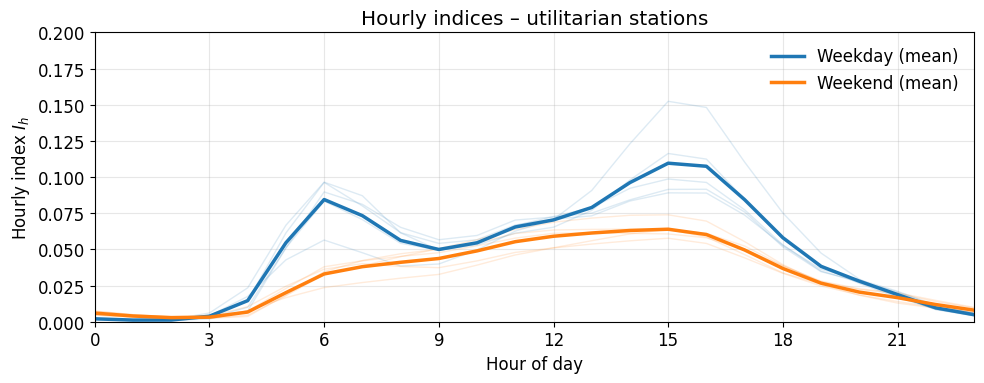

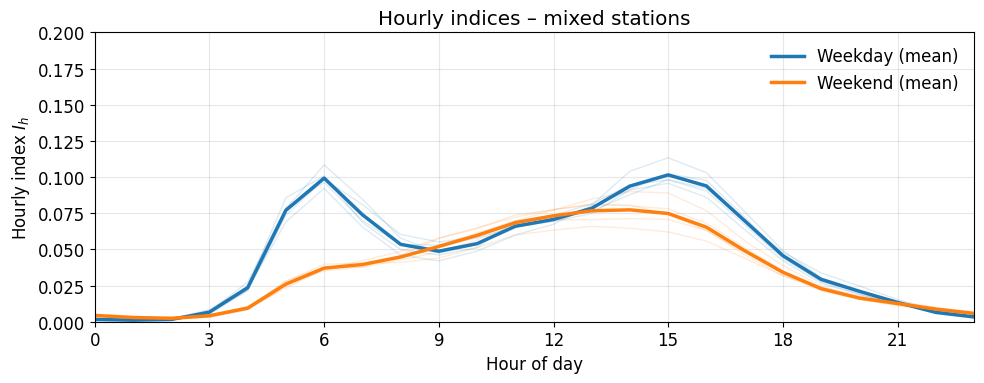

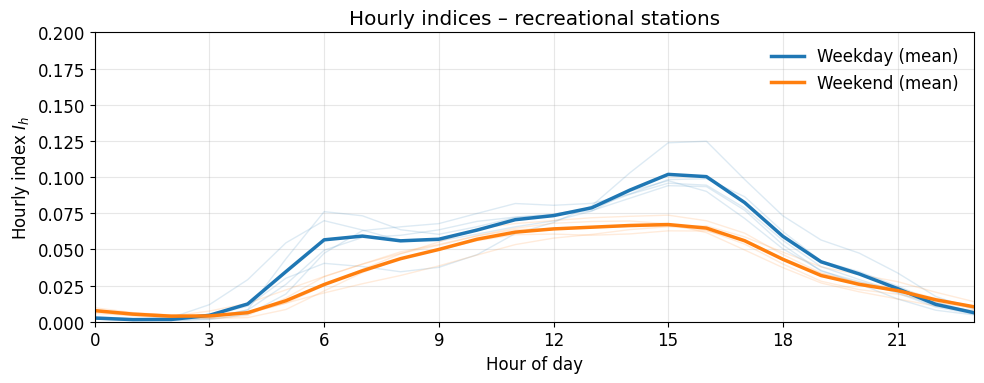

In [12]:
from analysis.characterisation.plotting.plot_indices import plot_hourly_indices_all

plot_hourly_indices_all(
    dl,
    stations=stations_utilitarian,
    title="Hourly indices – utilitarian stations"
)
plot_hourly_indices_all(
    dl,
    stations=stations_mixed,
    title="Hourly indices – mixed stations"
)
plot_hourly_indices_all(
    dl,
    stations=stations_recreational,
    title="Hourly indices – recreational stations"
)

**Daily index**

All usage types show a strong reduction in bike traffic over the weekend. Mixed and recreational show a higher usage level then utilitarian. 

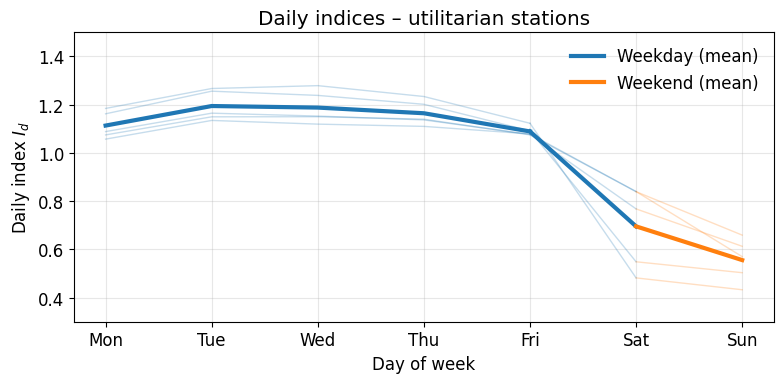

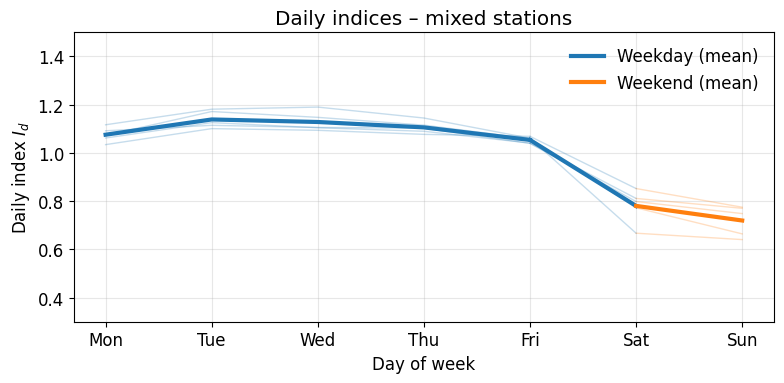

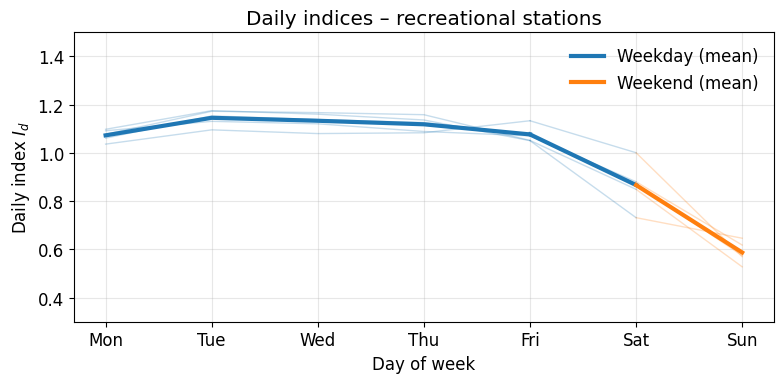

In [13]:
from analysis.characterisation.plotting.plot_indices import plot_daily_indices_all

plot_daily_indices_all(
    dl,
    stations=stations_utilitarian,
    title="Daily indices – utilitarian stations"
)
plot_daily_indices_all(
    dl,
    stations=stations_mixed,
    title="Daily indices – mixed stations"
)
plot_daily_indices_all(
    dl,
    stations=stations_recreational,
    title="Daily indices – recreational stations"
)

**Monthly index**

We see a large a large August drop in utilitarian stations, while the drop is smaller in recreational and mixed stations.

We can see a steep increase in recreational usage at the beginning of the year 

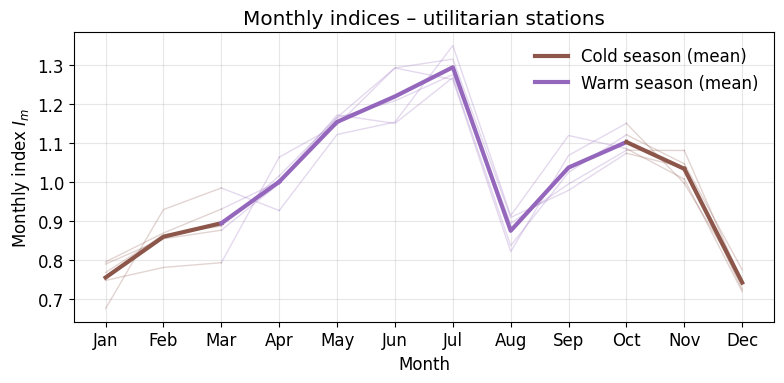

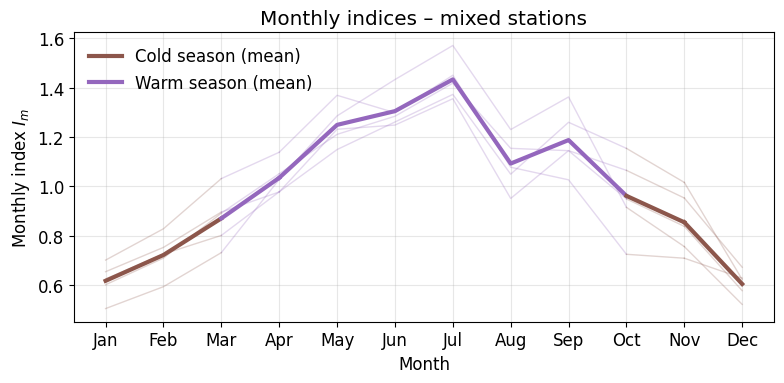

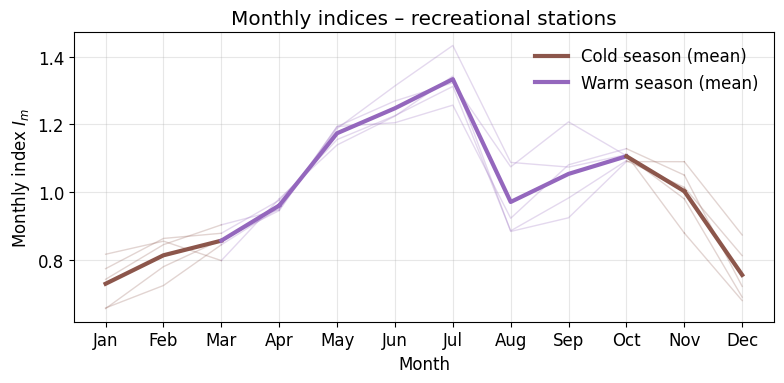

In [14]:
from analysis.characterisation.plotting.plot_indices import plot_monthly_indices_all

plot_monthly_indices_all(
    dl,
    stations=stations_utilitarian,
    title="Monthly indices – utilitarian stations"
)
plot_monthly_indices_all(
    dl,
    stations=stations_mixed,
    title="Monthly indices – mixed stations"
)
plot_monthly_indices_all(
    dl,
    stations=stations_recreational,
    title="Monthly indices – recreational stations"
)